# **Dicoding - Belajar Pengembangan Machine Learning**
# Submission 3 - Image Classification Model Deployment

### Flowers Recognition<br>
https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

import os
import shutil
import zipfile

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakaputrawidyasf","key":"3d5ae91c469976eaffb6589099ee21a1"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


### Download Dataset

In [5]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 97% 218M/225M [00:02<00:00, 103MB/s] 
100% 225M/225M [00:02<00:00, 98.7MB/s]


In [6]:
zip_data = "flowers-recognition.zip"
zip_ref = zipfile.ZipFile(zip_data, "r")
zip_ref.extractall()
zip_ref.close()

### Preprocessing the Dataset

In [7]:
dataset_dir = os.path.join("flowers")
labels = os.listdir(dataset_dir)

In [8]:
label_and_items = {}

for label in labels:
  items = os.listdir(os.path.join(dataset_dir, label))
  label_and_items[label] = len(items)

label_and_items

{'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}

In [9]:
def remove_label(label):
  shutil.rmtree(os.path.join(dataset_dir, label))
  labels.remove(label)
  label_and_items.pop(label)

In [10]:
remove_label("dandelion")
remove_label("tulip")

In [11]:
labels

['daisy', 'sunflower', 'rose']

In [12]:
label_and_items

{'daisy': 764, 'rose': 784, 'sunflower': 733}

### Split into Training and Validation set

In [13]:
datagen = ImageDataGenerator(rescale=1./255.0,
                             rotation_range=20,
                             horizontal_flip=True,
                             shear_range=0.2,
                             zoom_range=0.2,
                             fill_mode="nearest",
                             validation_split=0.2)

In [14]:
image_size = (150, 150)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    subset="training")
    
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    subset="validation")

Found 1827 images belonging to 3 classes.
Found 454 images belonging to 3 classes.


### Sequential Model

In [15]:
input_shape = (150, 150, 3)

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu",
                        input_shape=input_shape),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(len(labels), activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

### Model Training & Validation

In [16]:
class CustomCallBack(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get("accuracy") >= 0.9000 and logs.get("val_accuracy") >= 0.9000:
      print("Accuracy & Val accuracy was over 85%. Stop training...")
      self.model.stop_training = True

callbacks = CustomCallBack()

In [17]:
history = model.fit(train_generator,
                    epochs=32,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/32
58/58 [==============================] - 95s 2s/step - loss: 0.8930 - accuracy: 0.6305 - val_loss: 0.6411 - val_accuracy: 0.7753
Epoch 2/32
58/58 [==============================] - 93s 2s/step - loss: 0.5717 - accuracy: 0.7668 - val_loss: 0.5902 - val_accuracy: 0.7819
Epoch 3/32
58/58 [==============================] - 93s 2s/step - loss: 0.5091 - accuracy: 0.7947 - val_loss: 0.5376 - val_accuracy: 0.7996
Epoch 4/32
58/58 [==============================] - 94s 2s/step - loss: 0.4721 - accuracy: 0.8172 - val_loss: 0.5109 - val_accuracy: 0.7952
Epoch 5/32
58/58 [==============================] - 93s 2s/step - loss: 0.4587 - accuracy: 0.8062 - val_loss: 0.5216 - val_accuracy: 0.8018
Epoch 6/32
58/58 [==============================] - 94s 2s/step - loss: 0.4171 - accuracy: 0.8396 - val_loss: 0.5271 - val_accuracy: 0.8106
Epoch 7/32
58/58 [==============================] - 93s 2s/step - loss: 0.3841 - accuracy: 0.8484 - val_loss: 0.5791 - val_accuracy: 0.7445
Epoch 8/32
58/58 [==

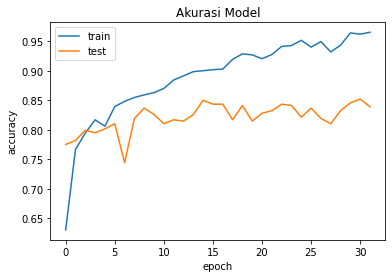

In [18]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Akurasi Model")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

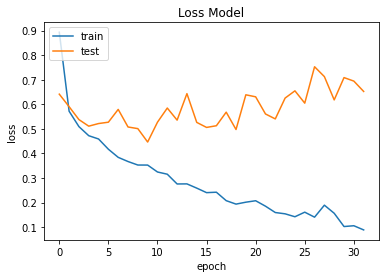

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Model")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### Deployment

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp8fmtvo6w/assets


In [21]:
with tf.io.gfile.GFile("model.tflite", "wb") as f:
  f.write(tflite_model)